# 2. Logistic Regression

- 작성자: [JWarmenhoven's Exercise 2](https://nbviewer.jupyter.org/github/JWarmenhoven/Machine-Learning/blob/master/notebooks/Programming%20Exercise%202%20-%20Logistic%20Regression.ipynb)

In [1]:
# basic data management or draw plots
import pandas as pd
import numpy as np
from scipy.special import expit

import matplotlib as mpl
import matplotlib.pyplot as plt
# add
import seaborn as sns

# polynomial modeling
from sklearn.preprocessing import PolynomialFeatures

# minimize optimizer
from scipy.optimize import minimize

# show option
%matplotlib inline
sns.set_context("notebook")
sns.set_style("white")

1. load data custom function

In [2]:
def loaddata(file, delimeter):
    data = pd.read_csv(file, sep=delimeter, header=None)
    print("Dimensions:", data.shape)
    print(data.head())
    return(data)

2. draw (plotting) data

In [3]:
def plotData(data, x_label, y_label, pos_label, neg_label, axes = None):
    # negative (y = 0), positive (y = 1)
    neg = data[2] == 0;  pos = data[2] == 1
    if axes is None:
        axes = plt.gca()

    axes.scatter(data[pos][0], data[pos][1], marker='+', c='k', s=60, linewidth=2,                 label=pos_label)
    axes.scatter(data[neg][0], data[neg][1], c='y', s=60, label=neg_label)
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.legend(frameon = True, fancybox = True);
    # ;를 쓰던가 show()를 사용하던가.

## Logistic regression

In [4]:
data = loaddata("https://nbviewer.jupyter.org/github/JWarmenhoven/Coursera-Machine-Learning/tree/master/notebooks/data/ex2data1.txt", ',')

Dimensions: (100, 3)
           0          1  2
0  34.623660  78.024693  0
1  30.286711  43.894998  0
2  35.847409  72.902198  0
3  60.182599  86.308552  1
4  79.032736  75.344376  1


In [5]:
X = np.c_[pd.concat([pd.DataFrame(np.ones((data.shape[0], 1))), data[data.columns[0:2]]], axis=1)]
y = np.c_[data[2]]

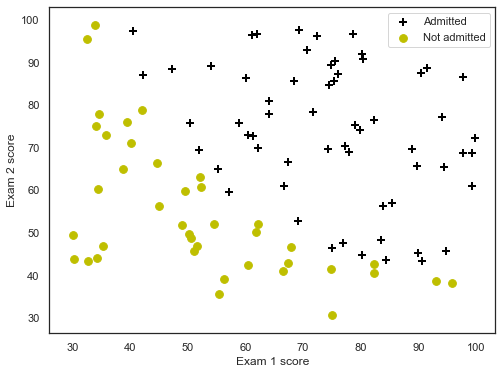

In [6]:
plt.figure(figsize=(8,6))
plotData(data, "Exam 1 score", "Exam 2 score", "Admitted", "Not admitted")

### Sigmoid function (logistic hypothesis)

In [7]:
def costFunction(theta, X, y):
    m = y.size
    h = expit(X.dot(theta))
    J = -(1/m) * (np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))
    
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

In [8]:
def gradient(theta, X, y):
    m = y.size
    h = expit(X.dot(theta.reshape(-1, 1)))
    grad = (1/m) * X.T.dot(h-y)
    return(grad.flatten())

In [9]:
initial_theta = np.zeros(X.shape[1])
cost = costFunction(initial_theta, X, y)
grad = gradient(initial_theta, X, y)
print("Cost:\n", cost)
print("Grad:\n", grad)

Cost:
 0.6931471805599453
Grad:
 [ -0.1        -12.00921659 -11.26284221]


### Optimize

In [10]:
res = minimize(costFunction, initial_theta, args=(X, y), method=None, jac=gradient,
               options={"maxiter": 400})
res

      fun: 0.2034977015895099
 hess_inv: array([[ 2.85339493e+03, -2.32908823e+01, -2.27416470e+01],
       [-2.32908823e+01,  2.04489131e-01,  1.72969525e-01],
       [-2.27416470e+01,  1.72969525e-01,  1.96170322e-01]])
      jac: array([-2.68557640e-09,  4.36433474e-07, -1.39671758e-06])
  message: 'Optimization terminated successfully.'
     nfev: 34
      nit: 25
     njev: 30
   status: 0
  success: True
        x: array([-25.16131634,   0.2062316 ,   0.20147143])

### Predict

In [11]:
def predict(theta, X, threshold=0.5):
    p = expit(X.dot(theta.T)) >= threshold
    return(p.astype("int"))

In [12]:
expit(np.array([1, 45, 85]).dot(res.x.T))

0.7762903249331018

In [13]:
p = predict(res.x, X)
print(f"Train accuracy {100 * sum(p == y.ravel())/p.size}%")

Train accuracy 89.0%


### Decision (linear) boundary

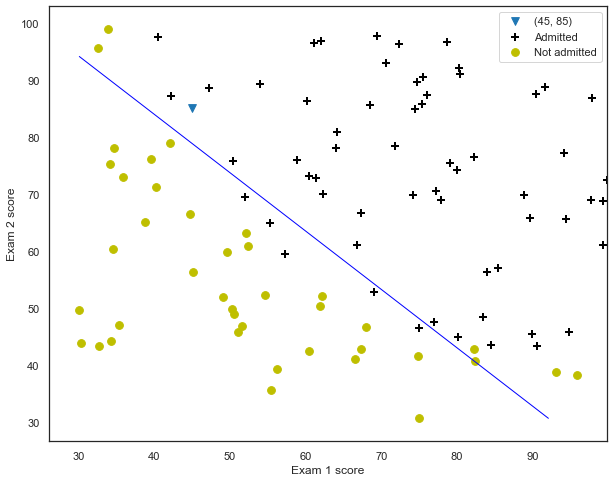

In [14]:
plt.figure(figsize=(10, 8))
plt.scatter(45, 85, s=60, marker='v', label="(45, 85)")
plotData(data, "Exam 1 score", "Exam 2 score", "Admitted", "Not admitted")

xx1, xx2 = np.meshgrid(np.linspace(X[:, 1].min(), X[:, 1].max()), np.linspace(X[:, 2].min(), X[:, 2].max()))
h = expit(np.c_[np.ones((xx1.ravel().shape[0], 1)), xx1.ravel(), xx2.ravel()].dot(res.x))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')

# plt.legend(loc="upper right")

## Regularized logistic regression

In [15]:
data2 = loaddata("https://nbviewer.jupyter.org/github/JWarmenhoven/Coursera-Machine-Learning/tree/master/notebooks/data/ex2data2.txt", ',')

Dimensions: (118, 3)
          0        1  2
0  0.051267  0.69956  1
1 -0.092742  0.68494  1
2 -0.213710  0.69225  1
3 -0.375000  0.50219  1
4 -0.513250  0.46564  1


In [16]:
X = data2[data2.columns[0:2]]
y = np.c_[data2[2]]

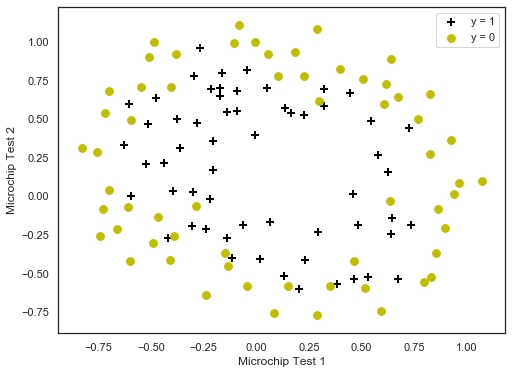

In [17]:
plt.figure(figsize=(8,6))
plotData(data2, "Microchip Test 1", "Microchip Test 2", "y = 1", "y = 0")

### Polynomials

In [18]:
poly = PolynomialFeatures(6)
XX = poly.fit_transform(X)
XX.shape

(118, 28)

In [19]:
def costFunctionReg(theta, reg, *args):
    m = y.size
    h = expit(XX.dot(theta))
    J = -(1/m) * (np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y)) \
        + (reg/(2*m))*np.sum(np.square(theta[1:]))
    
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

In [20]:
def gradientReg(theta, reg, *args):
    m = y.size
    h = expit(XX.dot(theta.reshape(-1, 1)))
    grad = (1/m)*XX.T.dot(h-y) + (reg/m)*np.r_[[[0]], theta[1:].reshape(-1, 1)]
    return(grad.flatten())

### first cost

In [21]:
initial_theta = np.zeros(XX.shape[1])
costFunctionReg(initial_theta, 1, XX, y)

0.6931471805599454

### Decision boundaries for other hyper-parameter

- lambda 0: no regularization, high variance
- lambda 1: looks about right
- lambda 100: too much, high bias

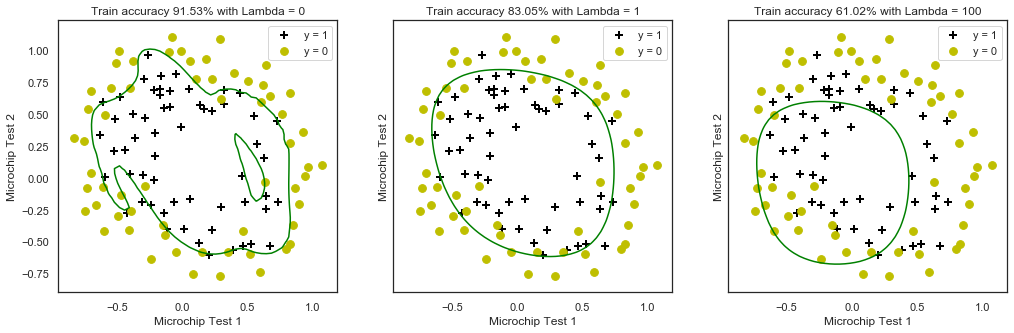

In [22]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(17,5))
for i, C in enumerate([0, 1, 100]):
    res = minimize(costFunctionReg, initial_theta, args=(C, XX, y), method=None, jac=gradientReg,
                   options={"maxiter": 30000})
    accuracy = 100 * sum(predict(res.x, XX) == y.ravel())/y.size

    plotData(data2, "Microchip Test 1", "Microchip Test 2", "y = 1", "y = 0", axes.flatten()[i])
    
    # draw decision boundary
    xx1, xx2 = np.meshgrid(np.linspace(X[0].min(), X[0].max()), np.linspace(X[1].min(), X[1].max()))
    h = expit(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res.x))
    h = h.reshape(xx1.shape)
    axes.flatten()[i].contour(xx1, xx2, h, [0.5], linewidth=1, colors='g')
    axes.flatten()[i].set_title(f"Train accuracy {round(accuracy, 2)}% with Lambda = {C}");